In [1]:
import math
import re
import sys
!{sys.executable} -m pip install pyfinance
from pyfinance.options import BSM
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

     |████████████████████████████████| 57 kB 4.7 MB/s eta 0:00:011


In [2]:
data = pd.read_excel("data/isx2010C.xls")
data = data.drop(data.columns[50], axis="columns")
data = data.rename(columns={data.columns[0]:'T', data.columns[48]:'S', data.columns[49]:'r'})
data.columns = data.columns.astype(str)
data['r'] /= 100
data['T_norm'] = data['T'] / 252
common = ['T', 'T_norm', 'S', 'r']
cols = [*common, *filter(lambda x: re.search('[0-9]+', x), data.columns)]
data = data[cols]

In [3]:
data.head()

,T,T_norm,S,r,340,345,350,355,360,365,370,375,380,385,390,395,400,405,410,415,420,425,430,435,440,445,450,455,460,465,470,475,480,485,490,495,500,505,510,515,520,525,530,535,540,545,550,555,560,565,570
0,86,0.341270,491.34,0.0011,152.20,NaN,NaN,NaN,132.60,NaN,NaN,NaN,113.20,NaN,NaN,NaN,94.55,NaN,NaN,NaN,76.45,NaN,NaN,NaN,59.25,NaN,NaN,NaN,43.60,NaN,NaN,NaN,29.80,NaN,NaN,NaN,18.65,NaN,NaN,NaN,10.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,85,0.337302,494.35,0.0011,155.05,NaN,NaN,NaN,135.35,NaN,NaN,NaN,115.90,NaN,NaN,NaN,96.90,NaN,NaN,NaN,78.75,NaN,NaN,NaN,61.45,NaN,NaN,NaN,45.45,NaN,NaN,NaN,31.40,NaN,NaN,NaN,19.80,NaN,NaN,NaN,11.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,84,0.333333,490.36,0.0011,152.40,NaN,NaN,NaN,132.70,NaN,NaN,NaN,113.30,NaN,NaN,NaN,94.35,NaN,NaN,NaN,76.15,NaN,NaN,NaN,59.05,NaN,NaN,NaN,43.40,NaN,NaN,NaN,29.55,NaN,NaN,NaN,18.45,NaN,NaN,NaN,10.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,83,0.329365,486.99,0.0011,147.00,NaN,NaN,NaN,127.25,NaN,NaN,NaN,108.05,NaN,NaN,NaN,89.70,NaN,NaN,NaN,71.95,NaN,NaN,NaN,55.25,NaN,NaN,NaN,39.70,NaN,NaN,NaN,26.95,NaN,NaN,NaN,16.45,NaN,NaN,NaN,8.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,82,0.325397,484.11,0.0011,145.55,NaN,NaN,NaN,125.95,NaN,NaN,NaN,106.75,NaN,NaN,NaN,88.10,NaN,NaN,NaN,70.35,NaN,NaN,NaN,53.65,NaN,NaN,NaN,38.60,NaN,NaN,NaN,25.70,NaN,NaN,NaN,15.70,NaN,NaN,NaN,7.95,NaN,NaN,NaN,3.8,NaN,NaN,NaN,1525.0,NaN,NaN


In [278]:
def test(S, E, r, T, Cobs, vola):
    eps = np.finfo(float).eps
    d1 = (np.log(S / E) + (r + vola**2 / 2) * T) / (np.sqrt(vola**2 * T) + eps)
    d2 = d1 - np.sqrt(vola**2 * T)
    C = norm.cdf(d1) * S - E * np.exp(-r * T) * norm.cdf(d2)
    C_prime = S * np.sqrt(T) * np.exp(-d1**2 / 2) / (np.sqrt(2*math.pi) + eps)
    vola = vola - (C - Cobs) / C_prime
    return abs(C - Cobs)

def vola(S, E, r, T, Cobs):
    eps = np.finfo(float).eps
    vola = 10
    tolerance = 0.015
    error = np.infty
    i = 0
    while error > tolerance:
        d1 = (math.log(S / E) + (r + vola**2 / 2) * T) / (math.sqrt(vola**2 * T) + eps)
        d2 = d1 - math.sqrt(vola**2 * T)
        C = norm.cdf(d1) * S - E * math.exp(-r * T) * norm.cdf(d2)
        C_prime = S * math.sqrt(T) * math.exp(-d1**2 / 2) / (math.sqrt(2*math.pi) + eps)
        vola = vola - (C - Cobs) / C_prime
        error = abs(C - Cobs)
        
    return vola

<ipython-input-278-0e69577c04d1>:21: RuntimeWarning: divide by zero encountered in double_scalars
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S / E) + (r + vola**2 / 2) * T) / (math.sqrt(vola**2 * T) + eps)
<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:21: RuntimeWarning: divide by zero encountered in double_scalars
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S / E) + (r + vola**2 / 2) * T) / (math.sqrt(vola**2 * T) + eps)
<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:21: RuntimeWarning: divide by zero encountered in double_scalars
  vola = vol

nan
nan
nan
nan
nan
nan
nan
nan


<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:17: RuntimeWarning: overflow encountered in double_scalars
  d1 = (math.log(S / E) + (r + vola**2 / 2) * T) / (math.sqrt(vola**2 * T) + eps)
<ipython-input-278-0e69577c04d1>:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S / E) + (r + vola**2 / 2) * T) / (math.sqrt(vola**2 * T) + eps)
<ipython-input-278-0e69577c04d1>:18: RuntimeWarning: overflow encountered in double_scalars
  d2 = d1 - math.sqrt(vola**2 * T)
<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: overflow encountered in true_divide
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:21: RuntimeWarning: divide by zero encountered in double_scalars
  vola = vola - (C - Cobs) / C_prim

nan
nan
nan
nan
nan
nan
nan


<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:21: RuntimeWarning: divide by zero encountered in double_scalars
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S / E) + (r + vola**2 / 2) * T) / (math.sqrt(vola**2 * T) + eps)
<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: overflow encountered in true_divide
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:21: RuntimeWarning: divide by zero encountered in double_scalars
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S / E) + (r + vola**2 / 2) * T) / (math.sqrt(vola*

nan
nan
nan
nan
nan
nan
nan
nan


<ipython-input-278-0e69577c04d1>:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S / E) + (r + vola**2 / 2) * T) / (math.sqrt(vola**2 * T) + eps)
<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:21: RuntimeWarning: divide by zero encountered in double_scalars
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S / E) + (r + vola**2 / 2) * T) / (math.sqrt(vola**2 * T) + eps)
<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:21: RuntimeWarning: divide by zero encountered in double_scalars
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.

nan
nan
nan
nan
nan
nan
nan
nan


<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:21: RuntimeWarning: divide by zero encountered in double_scalars
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S / E) + (r + vola**2 / 2) * T) / (math.sqrt(vola**2 * T) + eps)
<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:21: RuntimeWarning: divide by zero encountered in double_scalars
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S / E) + (r + vola**2 / 2) * T) / (math.sqrt(vola**2 * T) + eps)
<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - 

nan
nan
nan


<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:21: RuntimeWarning: divide by zero encountered in double_scalars
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S / E) + (r + vola**2 / 2) * T) / (math.sqrt(vola**2 * T) + eps)
<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:21: RuntimeWarning: divide by zero encountered in double_scalars
  vola = vola - (C - Cobs) / C_prime
<ipython-input-278-0e69577c04d1>:17: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (math.log(S / E) + (r + vola**2 / 2) * T) / (math.sqrt(vola**2 * T) + eps)
<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - 

nan
nan
nan
nan
nan
1.4139193346120194
1.6819707370033339
-0.15256198775628205


<ipython-input-278-0e69577c04d1>:7: RuntimeWarning: divide by zero encountered in true_divide
  vola = vola - (C - Cobs) / C_prime


nan

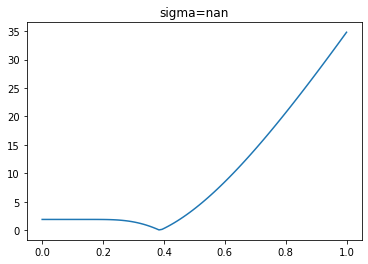

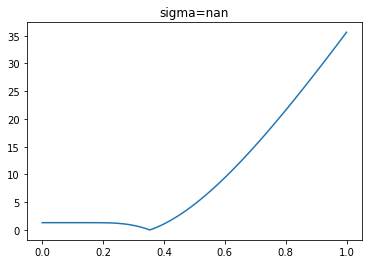

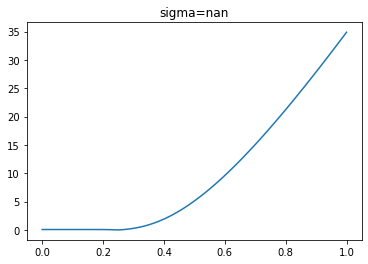

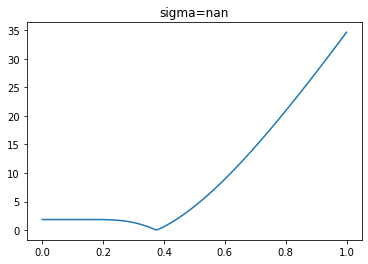

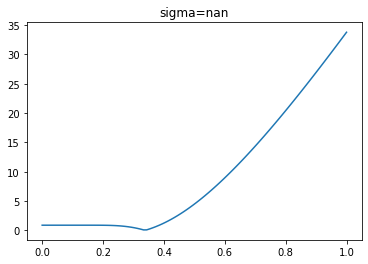

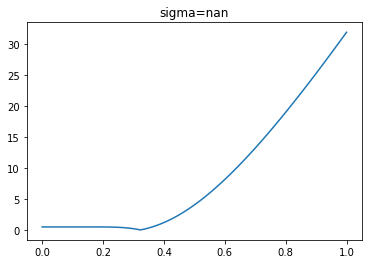

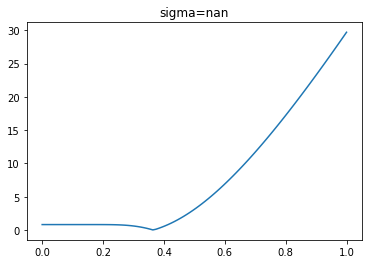

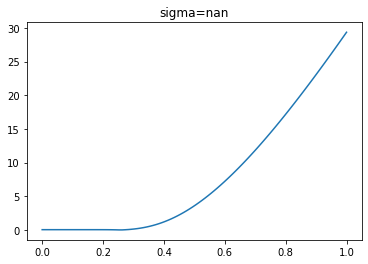

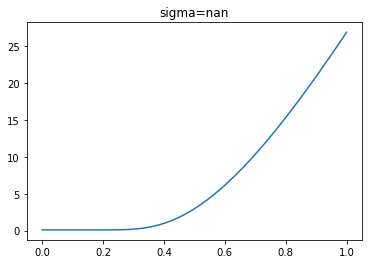

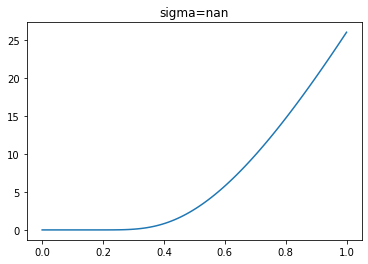

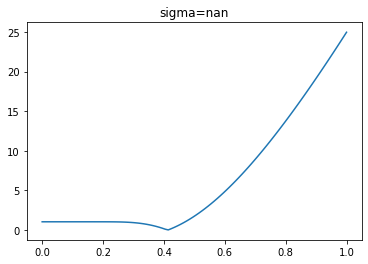

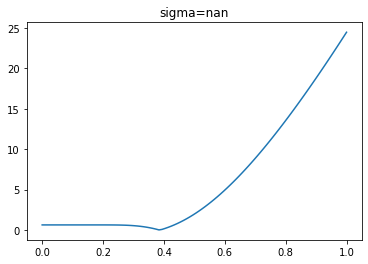

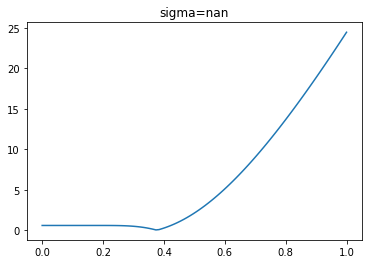

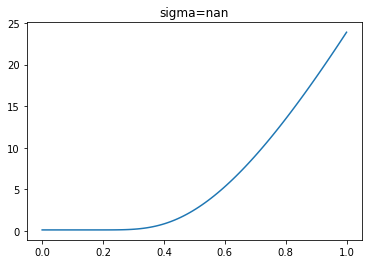

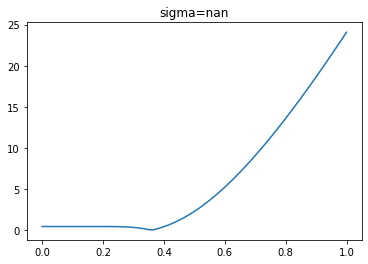

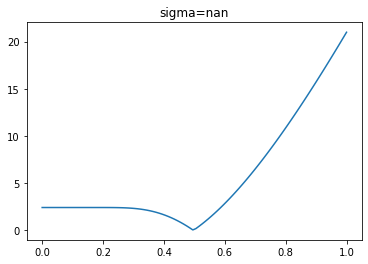

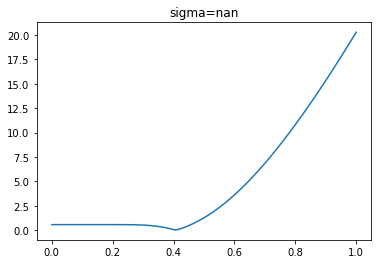

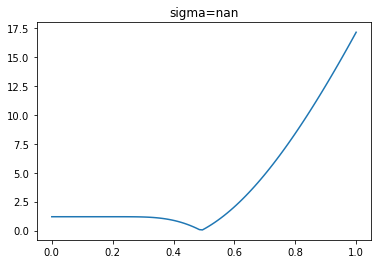

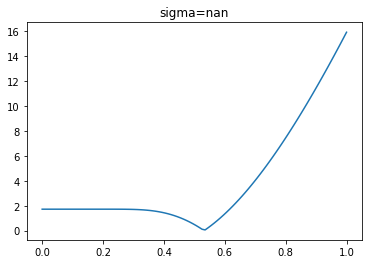

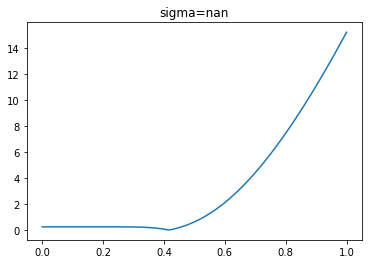

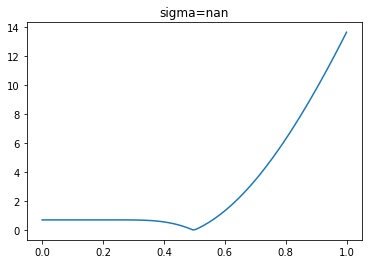

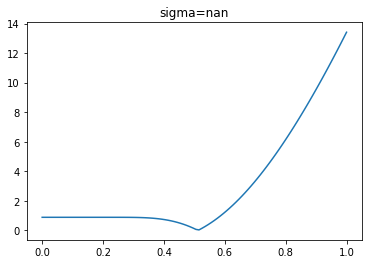

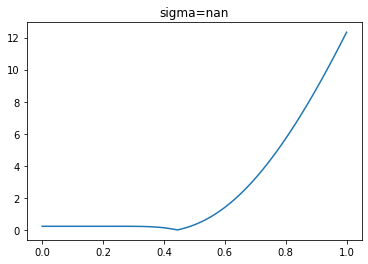

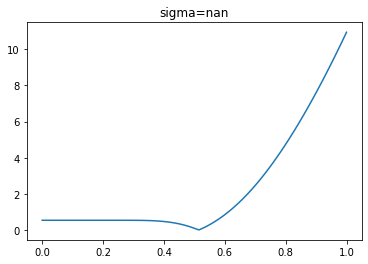

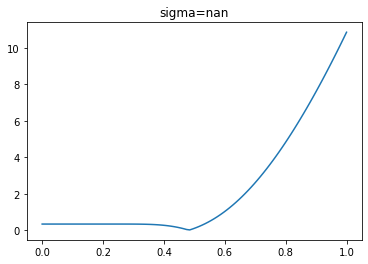

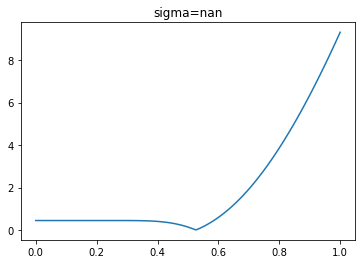

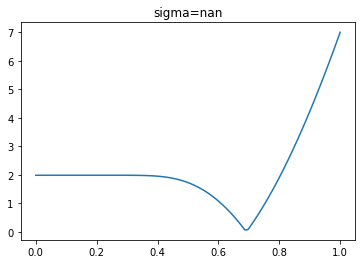

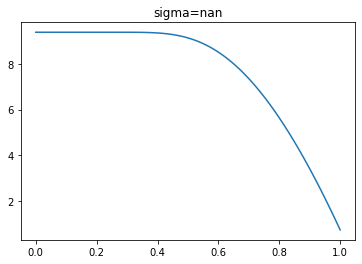

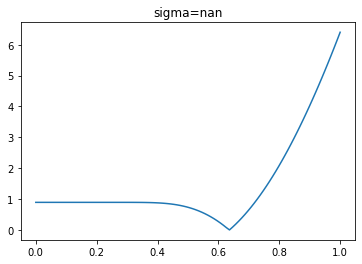

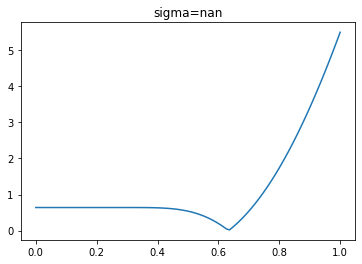

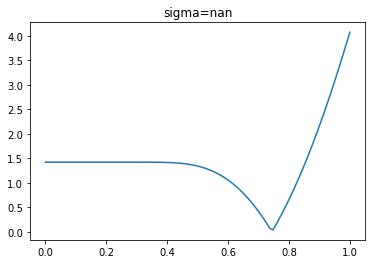

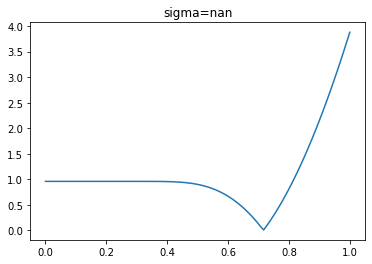

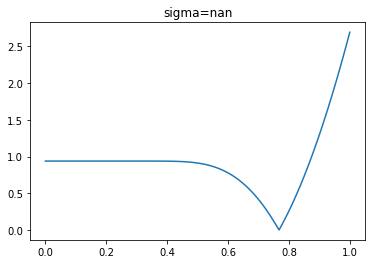

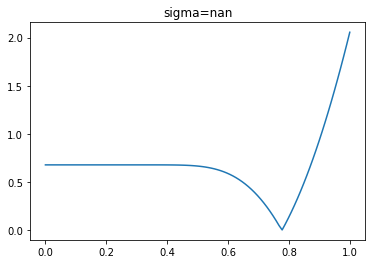

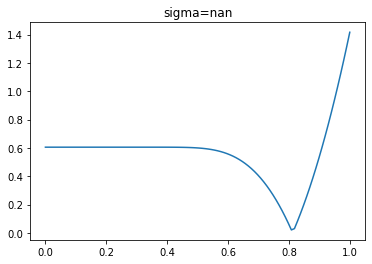

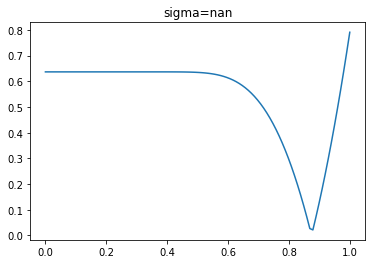

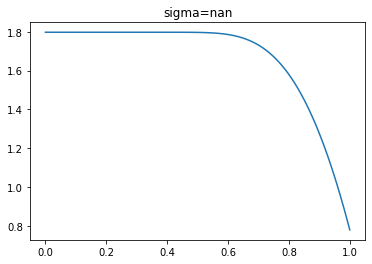

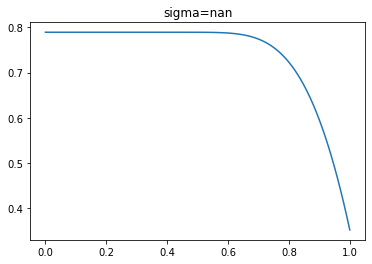

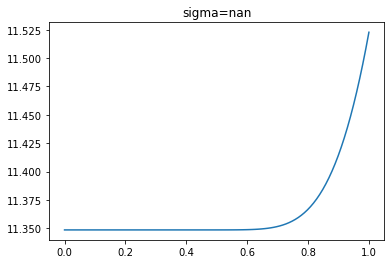

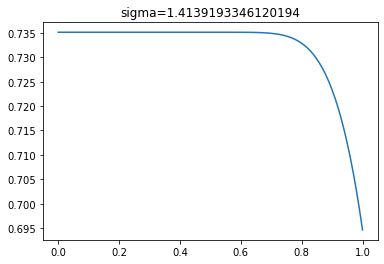

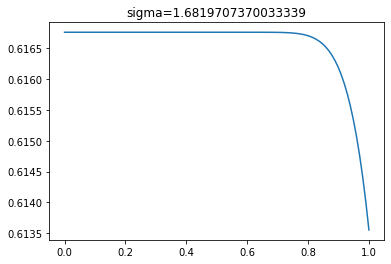

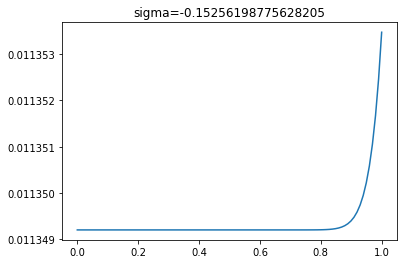

In [280]:
E = '340'
df_single = data[[*common, E]]

rows_iter = df_single.iterrows()
(index, row) = next(rows_iter)
long_prev = row[E]
S = row['S']
T = row['T_norm']
r = row['r']
bsm_tmp = BSM(S, int(E), T, r, 1)
sigma = bsm_tmp.implied_vol(row[E])
bsm = BSM(S, int(E), T, r, sigma)
delta = bsm.delta()
short_prev = delta * S

mse = 0

for index, row in rows_iter:
    long = row[E]
    short = delta * S
    dlong = long - long_prev
    dshort = short - short_prev
    mse += (dlong - dshort)**2 + 1
    long_prev = long
    short_prev = short
    
    if index % 2 == 0:
        S = row['S']
        T = row['T_norm']
        r = row['r']
        
        sigma = vola(S, int(E), r, T, row[E])
        print(sigma)
        fig, ax = plt.subplots()
        plt.plot(np.linspace(0, 1, 100), test(S,int(E), r, T, row[E], np.linspace(0, 1, 100)))
        plt.title(f'{sigma=}')
        d1 = (math.log(S/int(E)) + (r + sigma**2 / 2)*T)/(sigma * math.sqrt(T) + np.finfo(float).eps)
        delta = norm.cdf(d1)
    
mse

In [212]:
mse

nan